In [4]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Accumulation Phase LSTM Time Series'

In [5]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Accumulation Phase Stock Data

accumulation phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2001-01-08      22.3125  19.936626 -15.972222   192400.0     2.0
2001-01-09      20.5625  20.032914 -35.416667 -1320000.0     2.0
2001-01-10      20.7500  20.143235 -33.333333  -439800.0     2.0
2001-01-11      21.1250  20.294276 -29.166667   290200.0     2.0
2001-01-12      22.6875  20.662464 -13.178295  1360200.0     2.0


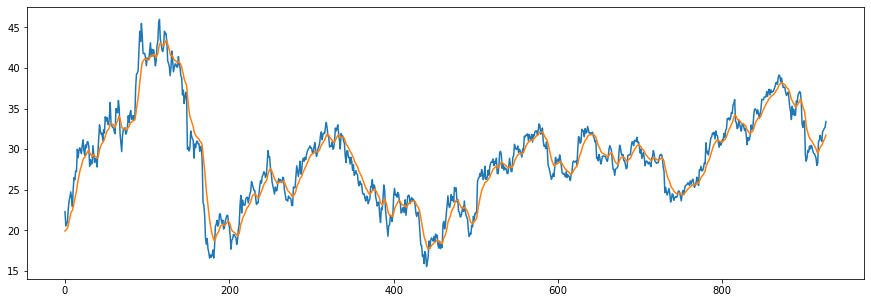

accumulation phase data\1_acc_data.csv
            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2013-10-21   122.519997  119.133586  -3.571469  268371800.0     2.0
2013-10-22   121.470001  119.493034 -14.600827  265163900.0     2.0
2013-10-23   122.480003  119.952568 -12.619492  269595100.0     2.0
2013-10-24   129.020004  121.347558  -5.825830  280361400.0     2.0
2013-10-25   128.979996  122.521779  -6.066121  275385200.0     2.0


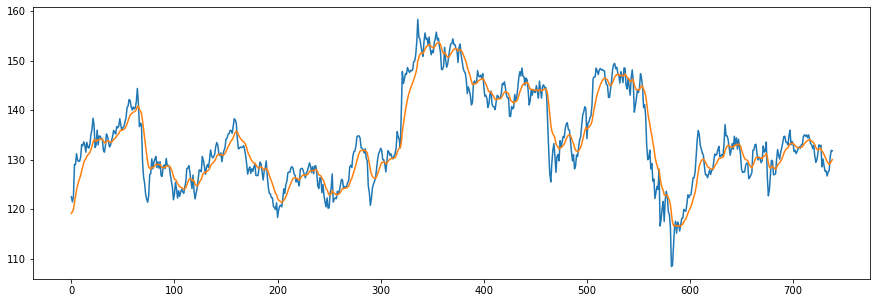

accumulation phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2011-06-02    16.940001  16.497632 -20.155042  9.557743e+09     2.0
2011-06-03    16.990000  16.573381 -24.475546  9.575374e+09     2.0
2011-06-07    17.440001  16.706707 -22.334963  9.601214e+09     2.0
2011-06-08    17.350000  16.805675 -26.903501  9.588997e+09     0.0
2011-06-09    17.760000  16.952494  -6.091318  9.611336e+09     2.0


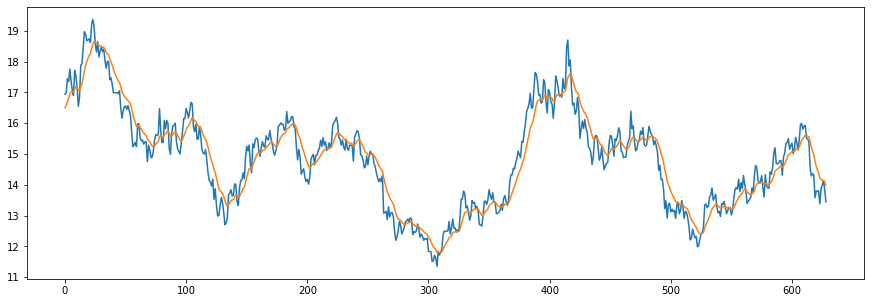

accumulation phase data\3_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-08-30     6.405571  6.389804 -28.571449  273414472.0     2.0
2004-08-31     6.405571  6.392230 -28.571449  273414472.0     2.0
2004-09-01     6.454098  6.401748 -19.999921  278125245.0     2.0
2004-09-02     6.551152  6.424733  -0.000000  288787337.0     2.0
2004-09-03     6.599679  6.451648  -0.000000  306525894.0     2.0


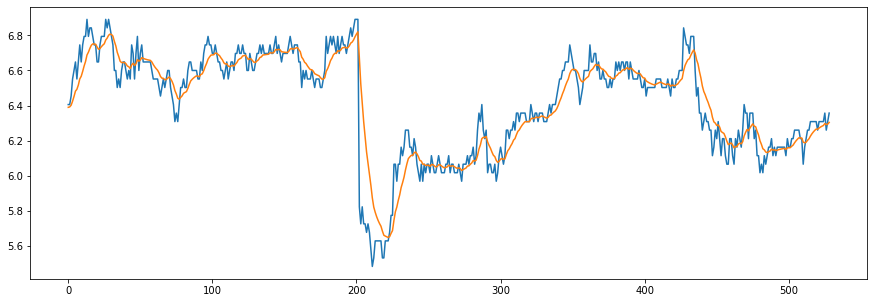

accumulation phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2009-08-03    38.650002  37.415266 -15.157111 -1.307058e+09     2.0
2009-08-04    39.599998  37.751379  -3.164588 -1.264100e+09     2.0
2009-08-05    40.209999  38.129628  -5.492443 -1.220737e+09     2.0
2009-08-06    41.779999  38.691224  -6.976777 -1.157402e+09     2.0
2009-08-07    40.750000  39.007958 -27.359985 -1.211578e+09     2.0


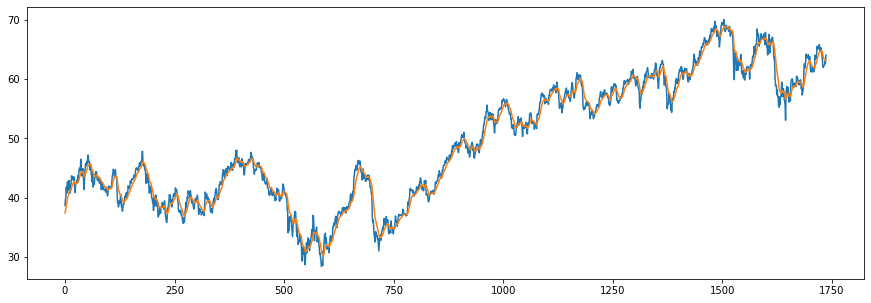

In [8]:
labels = []
sequential = []

for filepath in glob.iglob('accumulation phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4491, 15, 4)

In [10]:
y = labels
y = np.array(y)
y.shape

(4491,)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 4094, 0.0: 194, 1.0: 203})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
29/29 [==============================] - 1s 34ms/step - loss: 0.2953 - accuracy: 0.5078 - mse: 0.4427 - weighted_accuracy: 0.3022 - weighted_mse: 0.5274 - val_loss: 0.2997 - val_accuracy: 0.0456 - val_mse: 0.3538 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3538
Epoch 2/200
29/29 [==============================] - 0s 9ms/step - loss: 0.2143 - accuracy: 0.3472 - mse: 0.7577 - weighted_accuracy: 0.4345 - weighted_mse: 0.7350 - val_loss: 0.2924 - val_accuracy: 0.0456 - val_mse: 0.3854 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3854
Epoch 3/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1927 - accuracy: 0.2661 - mse: 0.9879 - weighted_accuracy: 0.4660 - weighted_mse: 0.9525 - val_loss: 0.2834 - val_accuracy: 0.0456 - val_mse: 0.4258 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.4258
Epoch 4/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1834 - accuracy: 0.2339 - mse: 1.1367 - weighted_accuracy: 0.4880 - weighte

Epoch 30/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1381 - accuracy: 0.3925 - mse: 1.6661 - weighted_accuracy: 0.6955 - weighted_mse: 1.5917 - val_loss: 0.1857 - val_accuracy: 0.3893 - val_mse: 1.5888 - val_weighted_accuracy: 0.3893 - val_weighted_mse: 1.5888
Epoch 31/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.3597 - mse: 1.7210 - weighted_accuracy: 0.6850 - weighted_mse: 1.6149 - val_loss: 0.1855 - val_accuracy: 0.4160 - val_mse: 1.5999 - val_weighted_accuracy: 0.4160 - val_weighted_mse: 1.5999
Epoch 32/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1387 - accuracy: 0.4198 - mse: 1.6600 - weighted_accuracy: 0.6916 - weighted_mse: 1.5867 - val_loss: 0.1880 - val_accuracy: 0.3971 - val_mse: 1.5939 - val_weighted_accuracy: 0.3971 - val_weighted_mse: 1.5939
Epoch 33/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1397 - accuracy: 0.3808 - mse: 1.6797 - weighted_accuracy: 0.6946 - weig

Epoch 59/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1303 - accuracy: 0.4382 - mse: 2.1267 - weighted_accuracy: 0.7262 - weighted_mse: 2.0783 - val_loss: 0.2057 - val_accuracy: 0.3515 - val_mse: 2.2182 - val_weighted_accuracy: 0.3515 - val_weighted_mse: 2.2182
Epoch 60/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1226 - accuracy: 0.4763 - mse: 2.0572 - weighted_accuracy: 0.7642 - weighted_mse: 2.0202 - val_loss: 0.1947 - val_accuracy: 0.4004 - val_mse: 2.1874 - val_weighted_accuracy: 0.4004 - val_weighted_mse: 2.1874
Epoch 61/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1194 - accuracy: 0.4922 - mse: 2.0534 - weighted_accuracy: 0.7599 - weighted_mse: 2.0169 - val_loss: 0.1799 - val_accuracy: 0.4616 - val_mse: 2.1230 - val_weighted_accuracy: 0.4616 - val_weighted_mse: 2.1230
Epoch 62/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1232 - accuracy: 0.4800 - mse: 2.1103 - weighted_accuracy: 0.7517 - weig

Epoch 88/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1014 - accuracy: 0.6128 - mse: 2.4971 - weighted_accuracy: 0.8362 - weighted_mse: 2.5218 - val_loss: 0.1763 - val_accuracy: 0.5261 - val_mse: 2.5667 - val_weighted_accuracy: 0.5261 - val_weighted_mse: 2.5667
Epoch 89/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1000 - accuracy: 0.6153 - mse: 2.5663 - weighted_accuracy: 0.8310 - weighted_mse: 2.5934 - val_loss: 0.1746 - val_accuracy: 0.5484 - val_mse: 2.5796 - val_weighted_accuracy: 0.5484 - val_weighted_mse: 2.5796
Epoch 90/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0973 - accuracy: 0.6356 - mse: 2.5636 - weighted_accuracy: 0.8424 - weighted_mse: 2.6195 - val_loss: 0.1764 - val_accuracy: 0.5484 - val_mse: 2.5909 - val_weighted_accuracy: 0.5484 - val_weighted_mse: 2.5909
Epoch 91/200
29/29 [==============================] - 0s 11ms/step - loss: 0.0950 - accuracy: 0.6498 - mse: 2.5997 - weighted_accuracy: 0.8599 - wei

Epoch 117/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0806 - accuracy: 0.7124 - mse: 3.1766 - weighted_accuracy: 0.8868 - weighted_mse: 3.2418 - val_loss: 0.1538 - val_accuracy: 0.6452 - val_mse: 3.3848 - val_weighted_accuracy: 0.6452 - val_weighted_mse: 3.3848
Epoch 118/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0986 - accuracy: 0.6311 - mse: 3.3714 - weighted_accuracy: 0.8326 - weighted_mse: 3.4463 - val_loss: 0.1803 - val_accuracy: 0.6096 - val_mse: 3.3870 - val_weighted_accuracy: 0.6096 - val_weighted_mse: 3.3870
Epoch 119/200
29/29 [==============================] - 0s 8ms/step - loss: 0.0985 - accuracy: 0.6066 - mse: 3.2668 - weighted_accuracy: 0.8403 - weighted_mse: 3.2578 - val_loss: 0.1595 - val_accuracy: 0.6574 - val_mse: 4.1819 - val_weighted_accuracy: 0.6574 - val_weighted_mse: 4.1819
Epoch 120/200
29/29 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.6893 - mse: 3.1814 - weighted_accuracy: 0.8644 - 

Epoch 146/200
29/29 [==============================] - 0s 8ms/step - loss: 0.0718 - accuracy: 0.7642 - mse: 3.5873 - weighted_accuracy: 0.9057 - weighted_mse: 3.6748 - val_loss: 0.1655 - val_accuracy: 0.6485 - val_mse: 3.8026 - val_weighted_accuracy: 0.6485 - val_weighted_mse: 3.8026
Epoch 147/200
29/29 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.7606 - mse: 3.6347 - weighted_accuracy: 0.9023 - weighted_mse: 3.7326 - val_loss: 0.1798 - val_accuracy: 0.5773 - val_mse: 3.7839 - val_weighted_accuracy: 0.5773 - val_weighted_mse: 3.7839
Epoch 148/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0734 - accuracy: 0.7458 - mse: 3.6453 - weighted_accuracy: 0.9010 - weighted_mse: 3.7002 - val_loss: 0.1454 - val_accuracy: 0.7019 - val_mse: 3.8965 - val_weighted_accuracy: 0.7019 - val_weighted_mse: 3.8965
Epoch 149/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0723 - accuracy: 0.7751 - mse: 3.6978 - weighted_accuracy: 0.9079 - 

Epoch 175/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0614 - accuracy: 0.8032 - mse: 4.0557 - weighted_accuracy: 0.9219 - weighted_mse: 4.1462 - val_loss: 0.1665 - val_accuracy: 0.6630 - val_mse: 3.8976 - val_weighted_accuracy: 0.6630 - val_weighted_mse: 3.8976
Epoch 176/200
29/29 [==============================] - 0s 10ms/step - loss: 0.0626 - accuracy: 0.8004 - mse: 4.0937 - weighted_accuracy: 0.9229 - weighted_mse: 4.1567 - val_loss: 0.1669 - val_accuracy: 0.6641 - val_mse: 4.2468 - val_weighted_accuracy: 0.6641 - val_weighted_mse: 4.2468
Epoch 177/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0634 - accuracy: 0.7820 - mse: 4.1456 - weighted_accuracy: 0.9203 - weighted_mse: 4.2587 - val_loss: 0.1563 - val_accuracy: 0.6930 - val_mse: 4.1783 - val_weighted_accuracy: 0.6930 - val_weighted_mse: 4.1783
Epoch 178/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0605 - accuracy: 0.8121 - mse: 4.2097 - weighted_accuracy: 0.9293 -

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1537308543920517
Test accuracy: 0.7152391672134399


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.1532305 -3.2463374  0.7552026]
 [-1.810131  -4.7973924  1.4067827]
 [-2.2767735 -2.062683   0.6076135]
 ...
 [-3.3274336 -3.9305074  2.7777596]
 [-1.5080338 -3.246787   0.7453516]
 [-3.392323  -1.7632226  1.0011425]]


Counter({2: 698, 1: 100, 0: 101})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 819, 1: 41, 0: 39})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 899
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 35
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 32
actual holds but predicted buy: 93
actual holds but predicted sell: 95
actual predicted holds: 631
Percentage buys correct: 14.634146341463415%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 77.04517704517704%
actual buys: 41
actual sells: 39
actual holds: 819


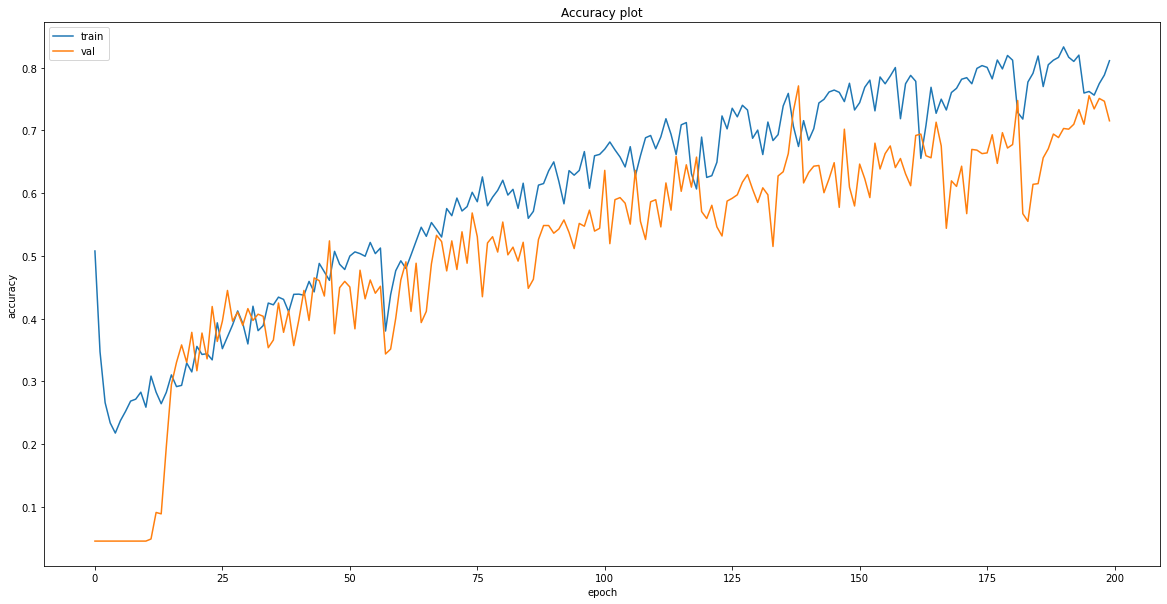

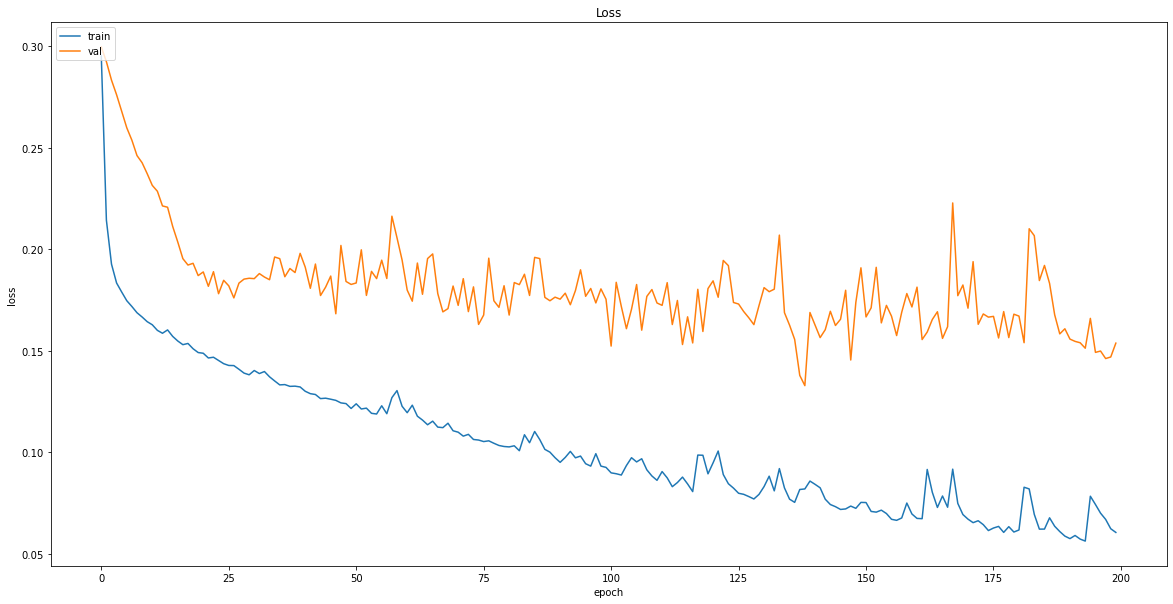

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('accumulation_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/accumulation_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Accumulation Phase Test Data

In [24]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [25]:
seed = 10
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0


In [26]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [27]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(248, 15, 4)

In [28]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [29]:
model = tf.keras.models.load_model("models/accumulation_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

8/8 [==============================] - 0s 4ms/step - loss: 0.1370 - accuracy: 0.7540 - mean_squared_error: 4.9230 - weighted_accuracy: 0.7540 - weighted_mean_squared_error: 4.9230
Test loss: 0.13696426153182983
Test accuracy: 0.7540322542190552


In [30]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 195, 1: 26, 0: 27})

In [31]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 229, 1: 11, 0: 8})

In [32]:
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [33]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2004-07-01,93.650002,92.599542,-13.252981,56757300.0,2.0,2,2
2004-07-02,93.610001,92.761151,-20.080318,52187800.0,2.0,2,2
2004-07-06,92.199997,92.891743,-20.615805,48857200.0,2.0,1,2
2004-07-07,90.570000,92.785321,-39.491353,46253500.0,2.0,2,2
2004-07-08,90.000000,92.444502,-61.311929,41751600.0,2.0,2,2


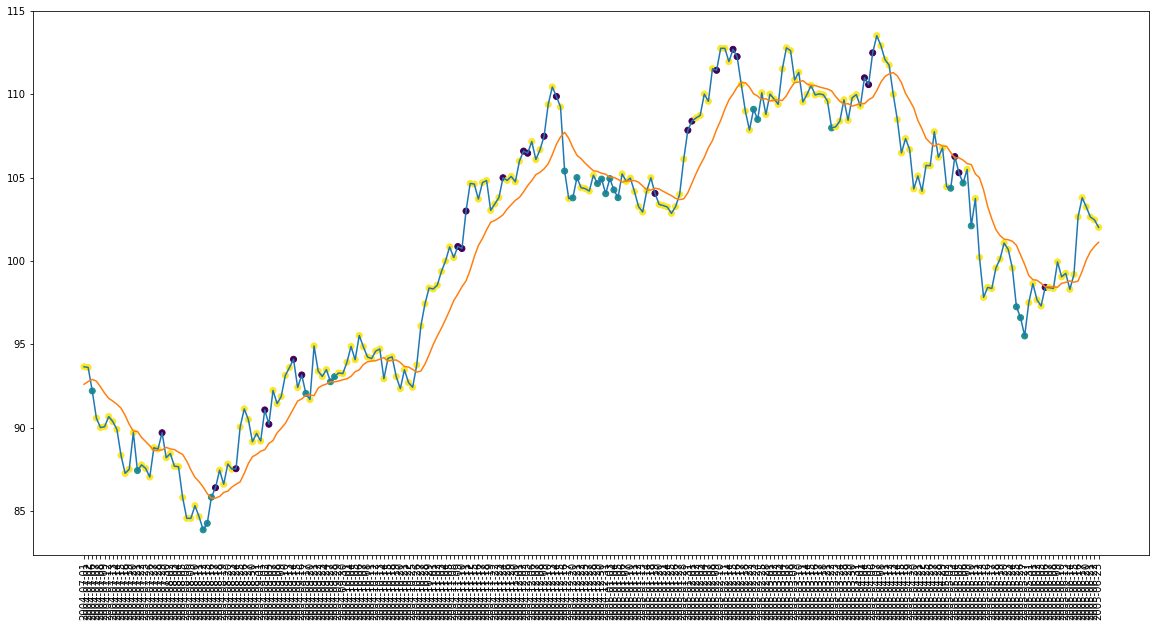

In [34]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [35]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 248
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 22
actual holds but predicted sell: 25
actual predicted holds: 182
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 25.0%
Percentage holds correct: 79.47598253275109%
actual buys: 11
actual sells: 8
actual holds: 229


In [36]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[89.88999938964844, 90.0, 90.05000305175781, 90.36000061035156, 90.56999969482422, 90.66000366210938, 92.1999969482422, 93.61000061035156, 93.6500015258789]
[87.25, 87.41999816894531, 87.5, 87.76000213623047, 88.33000183105469, 89.69999694824219, 89.88999938964844, 90.36000061035156, 90.66000366210938]
Percentage buys correct: 65.38461538461539%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 83.07692307692308%


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[89.88999938964844, 90.0, 90.05000305175781, 90.36000061035156, 90.56999969482422, 90.66000366210938, 92.1999969482422, 93.61000061035156, 93.6500015258789]
[87.25, 87.41999816894531, 87.5, 87.76000213623047, 88.33000183105469, 89.69999694824219, 89.88999938964844, 90.36000061035156, 90.66000366210938]
Percentage buys correct: 65.38461538461539%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 83.07692307692308%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $92.1999969482422
Shares owned at the moment: 108
Cash capital at the moment: $15.016930496212808


Stop Loss Activated!

Share price: $88.33000183105469
Shares owned at the moment: 0
Cash capital at the moment: $9528.423117706296


Share price: $87.41999816894531
Shares owned at the moment: 108
Cash capital at the moment: $61.09957600402413


Stop Loss Activated!

Share price: $84.55000305175781
Shares owned at the moment: 0
Cash capital at the moment: $9167.388554687495


Share price: $83.86000061035156
Shares owned at the moment: 109
Cash capital at the moment: $1.5114529762213351


Price increase from previously bought: 8.287942591261865%
Share price: $91.05999755859376
Shares owned at the moment: 0
Cash capital at the moment: $9899.755952594753


Share price: $92.0500030517578
Shares owned at the moment: 107
Cash capital at the moment: $23.319912658687826


Price increase from previously bought: 9.281225031394502%
Share price: $100.87000274658205
Shares owned at the m

In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10830.181677955627
profit gained: 8.301816779556265%


In [40]:
logger

[0.7540322542190552,
 '27.272727272727273%',
 '25.0%',
 '79.47598253275109%',
 '65.38461538461539%',
 '55.55555555555556%',
 '83.07692307692308%',
 '7.481157219867674%',
 '8.301816779556265%']

In [41]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.754032,27.272727272727273%,25.0%,79.47598253275109%,65.38461538461539%,55.55555555555556%,83.07692307692308%,7.481157219867674%,8.301816779556265%


### Mark Up Phase Test Data

In [42]:
logger = []

In [44]:
seed = 10
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [45]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [46]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [47]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [48]:
model = tf.keras.models.load_model("models/accumulation_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1192 - accuracy: 0.8219 - mean_squared_error: 4.9347 - weighted_accuracy: 0.8219 - weighted_mean_squared_error: 4.9347
Test loss: 0.119199238717556
Test accuracy: 0.8219178318977356


In [49]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 14, 1: 15})

In [50]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [51]:
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [52]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,115.250000,115.943088,-17.142986,-11228200.0,2.0,2,2
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,0


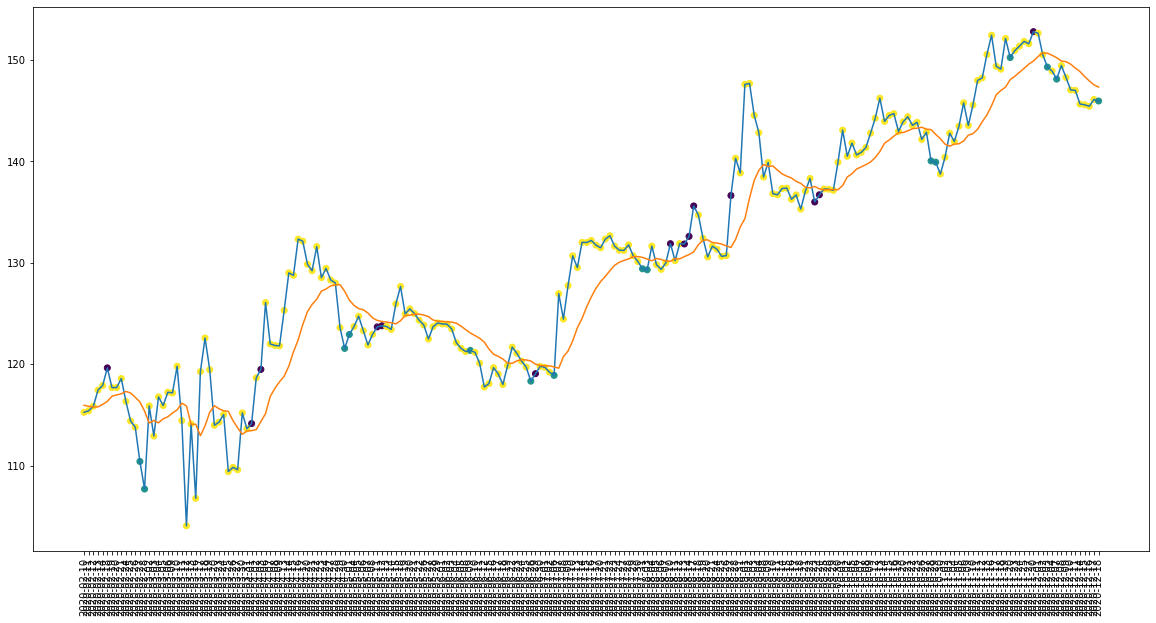

In [53]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [54]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 12
actual holds but predicted sell: 13
actual predicted holds: 176
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 87.56218905472637%
actual buys: 7
actual sells: 11
actual holds: 201


In [55]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[115.25, 115.4000015258789, 115.8499984741211, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.68000030517578, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 93.33333333333333%
Percentage sells correct: 42.857142857142854%
Percentage holds correct: 86.84210526315789%


In [56]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $110.4000015258789
Shares owned at the moment: 90
Cash capital at the moment: $36.67586229324297


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $9375.423761196134


Share price: $121.5500030517578
Shares owned at the moment: 76
Cash capital at the moment: $112.21957862472482


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $9035.851756717679


Share price: $118.31999969482422
Shares owned at the moment: 76
Cash capital at the moment: $18.80289997482032


Price increase from previously bought: 11.154775030399655%
Share price: $131.8800048828125
Shares owned at the moment: 0
Cash capital at the moment: $10014.120350048062


Share price: $140.03999328613278
Shares owned at the moment: 71
Cash capital at the moment: $43.93801804351642


Price increase from previously bought: 8.805327345847825%
Share price: $152.7899932861328
Shares owned at the m

In [57]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12578.425938270568
profit gained: 25.784259382705677%


In [58]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.754032,27.272727272727273%,25.0%,79.47598253275109%,65.38461538461539%,55.55555555555556%,83.07692307692308%,7.481157219867674%,8.301816779556265%
1,0.821918,42.857142857142854%,9.090909090909092%,87.56218905472637%,93.33333333333333%,42.857142857142854%,86.84210526315789%,5.625353557167019%,25.784259382705677%


### Distribution Phase Test Data

In [59]:
logger = []

In [60]:
seed = 10
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2016-12-05   223.360001  213.378658 -16.514565 -283274800.0     2.0
2016-12-06   228.550003  215.712711  -2.667189 -278675500.0     2.0
2016-12-07   231.380005  218.123064  -4.633597 -273416200.0     2.0
2016-12-08   235.559998  220.805669  -1.742271 -266821000.0     2.0
2016-12-09   241.449997  223.981719  -2.918174 -259477300.0     2.0


In [61]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(470, 15, 4)

In [63]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [64]:
model = tf.keras.models.load_model("models/accumulation_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

15/15 [==============================] - 0s 3ms/step - loss: 0.1550 - accuracy: 0.7362 - mean_squared_error: 4.6662 - weighted_accuracy: 0.7362 - weighted_mean_squared_error: 4.6662
Test loss: 0.15497075021266937
Test accuracy: 0.73617023229599


In [65]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 370, 1: 53, 0: 47})

In [66]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 426, 1: 24, 0: 20})

In [67]:
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [68]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2016-12-23,240.970001,237.434924,-26.807731,-247920400.0,2.0,2,2
2016-12-27,241.559998,237.978782,-26.032839,-245732900.0,2.0,1,2
2016-12-28,240.649994,238.529738,-26.433792,-243734700.0,2.0,1,2
2016-12-29,238.179993,238.855931,-48.235368,-246787700.0,1.0,1,1
2016-12-30,239.449997,238.751941,-72.451037,-249406700.0,2.0,2,2


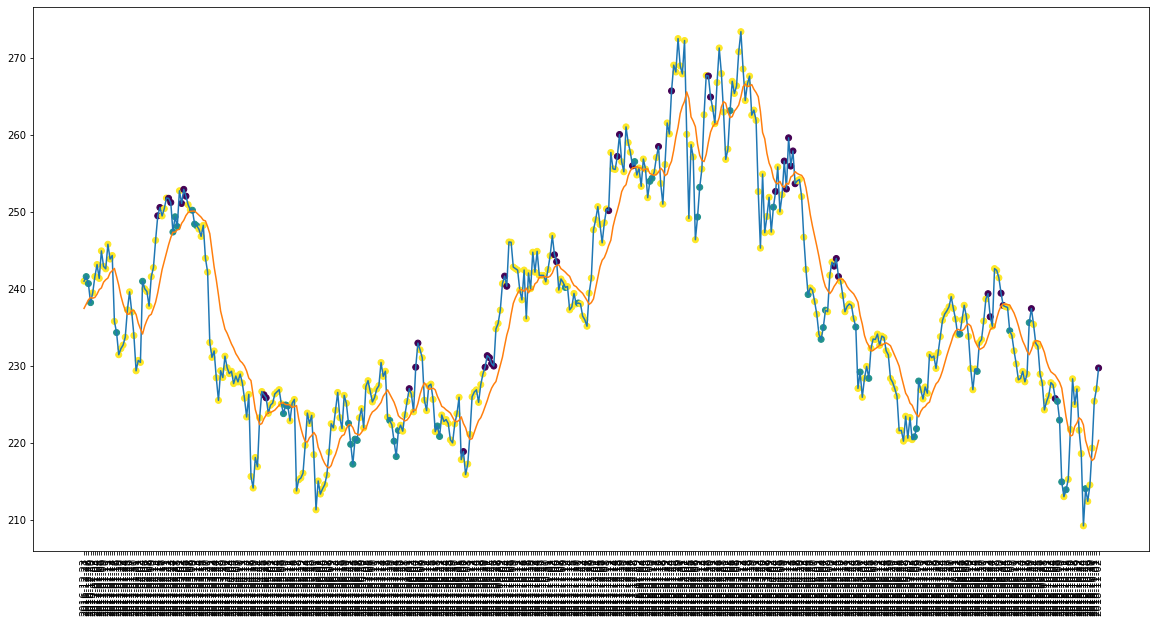

In [69]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

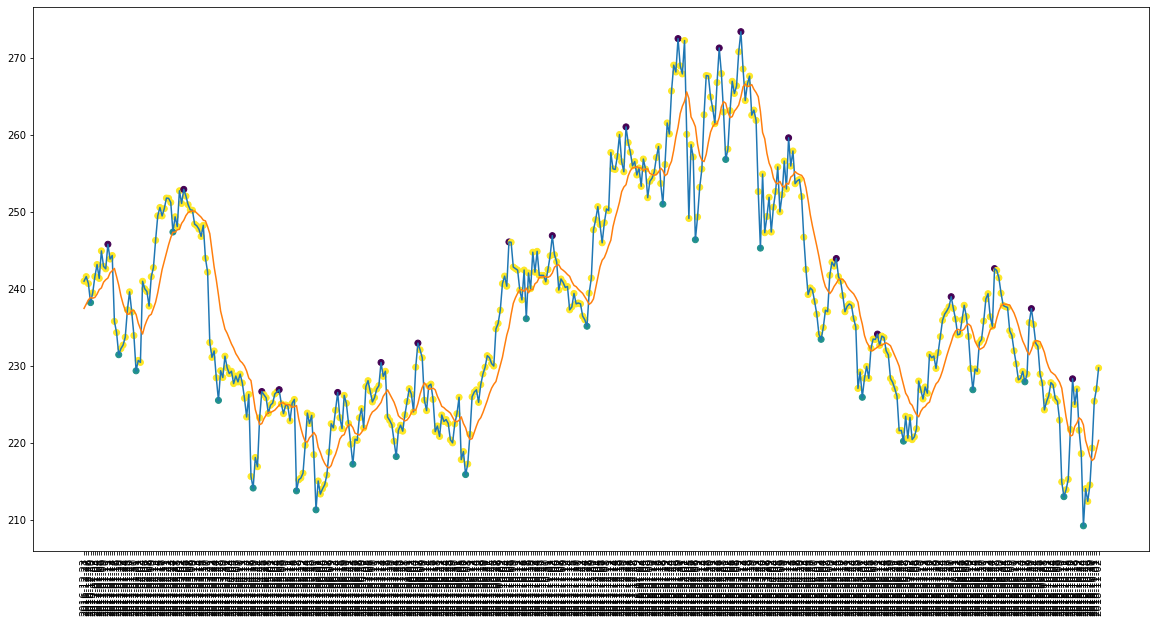

In [70]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [71]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 470
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 19
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 15
actual holds but predicted buy: 48
actual holds but predicted sell: 42
actual predicted holds: 336
Percentage buys correct: 20.833333333333332%
Percentage sells correct: 25.0%
Percentage holds correct: 78.87323943661971%
actual buys: 24
actual sells: 20
actual holds: 426


In [72]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[238.17999267578125, 239.4499969482422, 240.6499938964844, 240.97000122070312, 241.32000732421875, 241.55999755859366, 241.57000732421875, 243.1300048828125, 244.8999938964844]
[235.7400054931641, 241.32000732421875, 242.57000732421875, 242.88999938964844, 243.1300048828125, 243.83999633789062, 244.3000030517578, 244.8999938964844, 245.75999450683602]
Percentage buys correct: 64.15094339622641%
Percentage sells correct: 70.2127659574468%
Percentage holds correct: 84.28184281842819%


In [73]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $241.55999755859366
Shares owned at the moment: 41
Cash capital at the moment: $68.80421037292763


Stop Loss Activated!

Share price: $234.2899932861328
Shares owned at the moment: 0
Cash capital at the moment: $9648.277738361361


Share price: $234.2899932861328
Shares owned at the moment: 41
Cash capital at the moment: $15.97181688690398


Price increase from previously bought: 6.182884541347011%
Share price: $249.4600067138672
Shares owned at the moment: 0
Cash capital at the moment: $10215.70547639847


Share price: $247.3500061035156
Shares owned at the moment: 41
Cash capital at the moment: $46.466512966160735


Stop Loss Activated!

Share price: $233.0
Shares owned at the moment: 0
Cash capital at the moment: $9573.195762966161


Share price: $223.75999450683602
Shares owned at the moment: 42
Cash capital at the moment: $149.43171431350856


Stop Loss Activated!

Share price: $213.72000122070312
Shares owned at the moment: 0
Cash capital at the moment: $9100.987105

In [74]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9484.453134635925
profit gained: -5.155468653640746%


In [75]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.754032,27.272727272727273%,25.0%,79.47598253275109%,65.38461538461539%,55.55555555555556%,83.07692307692308%,7.481157219867674%,8.301816779556265%
1,0.821918,42.857142857142854%,9.090909090909092%,87.56218905472637%,93.33333333333333%,42.857142857142854%,86.84210526315789%,5.625353557167019%,25.784259382705677%
2,0.736170,20.833333333333332%,25.0%,78.87323943661971%,64.15094339622641%,70.2127659574468%,84.28184281842819%,-18.044984970779407%,-5.155468653640746%


### Mark Down Phase Test Data

In [92]:
logger = []

In [93]:
seed = 10
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2007-10-01   216.740005  205.638670  -5.220429  161688200.0     2.0
2007-10-02   222.979996  208.306567  -1.526716  171593800.0     2.0
2007-10-03   228.020004  211.339403  -1.071898  181013600.0     2.0
2007-10-04   227.350006  213.802573  -7.282412  170892200.0     2.0
2007-10-05   225.949997  215.671407 -10.566735  160852300.0     2.0


In [94]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [95]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(278, 15, 4)

In [96]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [97]:
model = tf.keras.models.load_model("models/accumulation_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

9/9 [==============================] - 0s 4ms/step - loss: 0.1486 - accuracy: 0.7410 - mean_squared_error: 5.5381 - weighted_accuracy: 0.7410 - weighted_mean_squared_error: 5.5381
Test loss: 0.1486012190580368
Test accuracy: 0.7410072088241577


In [98]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 231, 0: 13, 1: 34})

In [99]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 16, 2: 249, 0: 13})

In [100]:
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [101]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2007-10-19,217.690002,226.848008,-48.765388,164382100.0,1.0,2,1
2007-10-22,222.179993,225.439084,-99.592777,151275300.0,2.0,2,2
2007-10-23,223.759995,224.937685,-65.618001,163438800.0,2.0,2,2
2007-10-24,225.119995,224.756502,-59.700390,171615400.0,2.0,2,2
2007-10-25,226.660004,224.812424,-54.606755,184266200.0,2.0,2,2


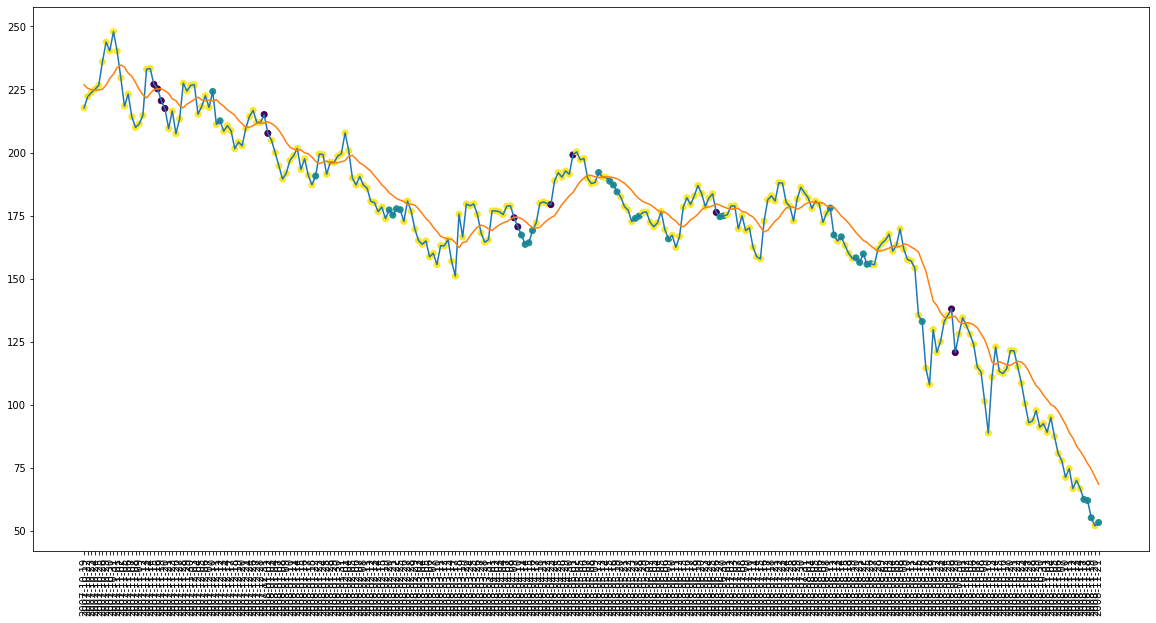

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

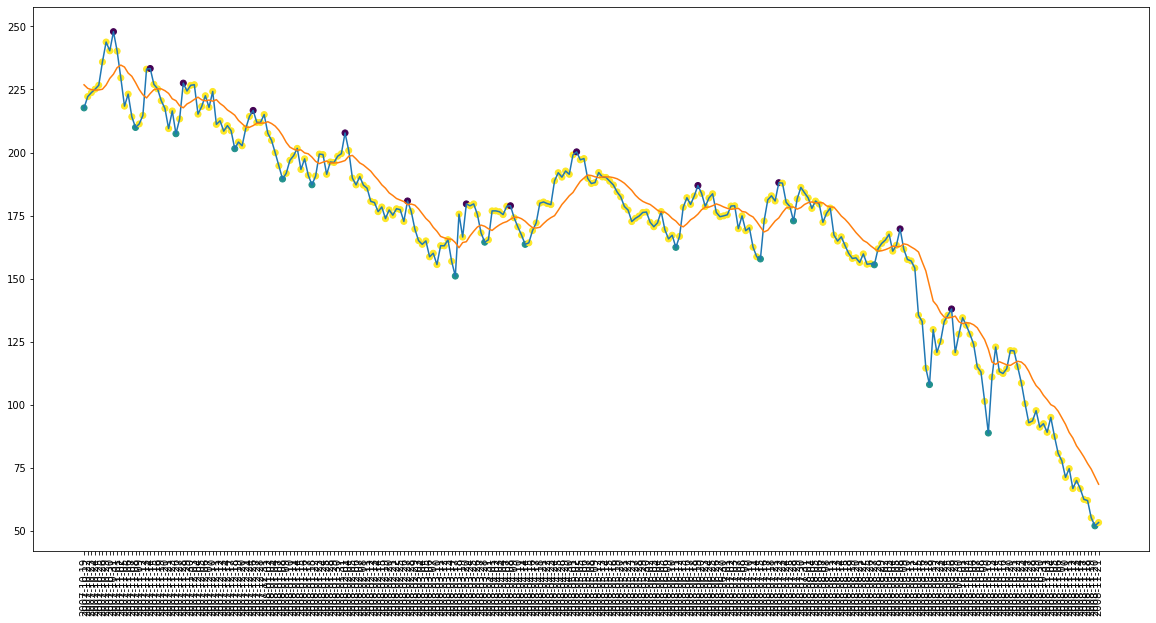

In [103]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [104]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 278
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 15
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 12
actual holds but predicted buy: 33
actual holds but predicted sell: 12
actual predicted holds: 204
Percentage buys correct: 6.25%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 81.92771084337349%
actual buys: 16
actual sells: 13
actual holds: 249


In [105]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[217.69000244140625, 222.17999267578125, 223.75999450683602, 225.1199951171875, 226.66000366210938, 235.9199981689453, 240.3300018310547, 243.80999755859366, 247.9199981689453]
[209.94000244140625, 214.17999267578125, 218.38999938964844, 223.16000366210938, 229.6000061035156, 240.2100067138672, 240.3300018310547, 243.80999755859366, 247.9199981689453]
Percentage buys correct: 48.484848484848484%
Percentage sells correct: 38.46153846153846%
Percentage holds correct: 82.25108225108225%


In [106]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $224.2100067138672
Shares owned at the moment: 44
Cash capital at the moment: $107.63029377746534


Stop Loss Activated!

Share price: $211.1499938964844
Shares owned at the moment: 0
Cash capital at the moment: $9372.680875961305


Share price: $212.5800018310547
Shares owned at the moment: 43
Cash capital at the moment: $206.60321200943145


Stop Loss Activated!

Share price: $201.50999450683602
Shares owned at the moment: 0
Cash capital at the moment: $8847.704418952946


Share price: $190.69000244140625
Shares owned at the moment: 46
Cash capital at the moment: $51.84202133942017


Stop Loss Activated!

Share price: $180.6499938964844
Shares owned at the moment: 0
Cash capital at the moment: $8338.889516349798


Share price: $177.25
Shares owned at the moment: 46
Cash capital at the moment: $162.96739134979816


Stop Loss Activated!

Share price: $169.6300048828125
Shares owned at the moment: 0
Cash capital at the moment: $7944.489420341497


Share price: $167.30000305

In [107]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $2569.3637014627457
profit gained: -74.30636298537254%


In [108]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.754032,27.272727272727273%,25.0%,79.47598253275109%,65.38461538461539%,55.55555555555556%,83.07692307692308%,7.481157219867674%,8.301816779556265%
1,0.821918,42.857142857142854%,9.090909090909092%,87.56218905472637%,93.33333333333333%,42.857142857142854%,86.84210526315789%,5.625353557167019%,25.784259382705677%
2,0.736170,20.833333333333332%,25.0%,78.87323943661971%,64.15094339622641%,70.2127659574468%,84.28184281842819%,-18.044984970779407%,-5.155468653640746%
3,0.741007,6.25%,7.6923076923076925%,81.92771084337349%,48.484848484848484%,38.46153846153846%,82.25108225108225%,-59.736331572036725%,-74.30636298537254%


### bull phase test data

In [109]:
logger = []

In [110]:
seed = 10
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [111]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [112]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [113]:
model = tf.keras.models.load_model("models/accumulation_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1402 - accuracy: 0.7308 - mean_squared_error: 4.9261 - weighted_accuracy: 0.7308 - weighted_mean_squared_error: 4.9261
Test loss: 0.14024414122104645
Test accuracy: 0.7307692170143127


In [114]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 162, 1: 14, 0: 32})

In [115]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [116]:
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [117]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


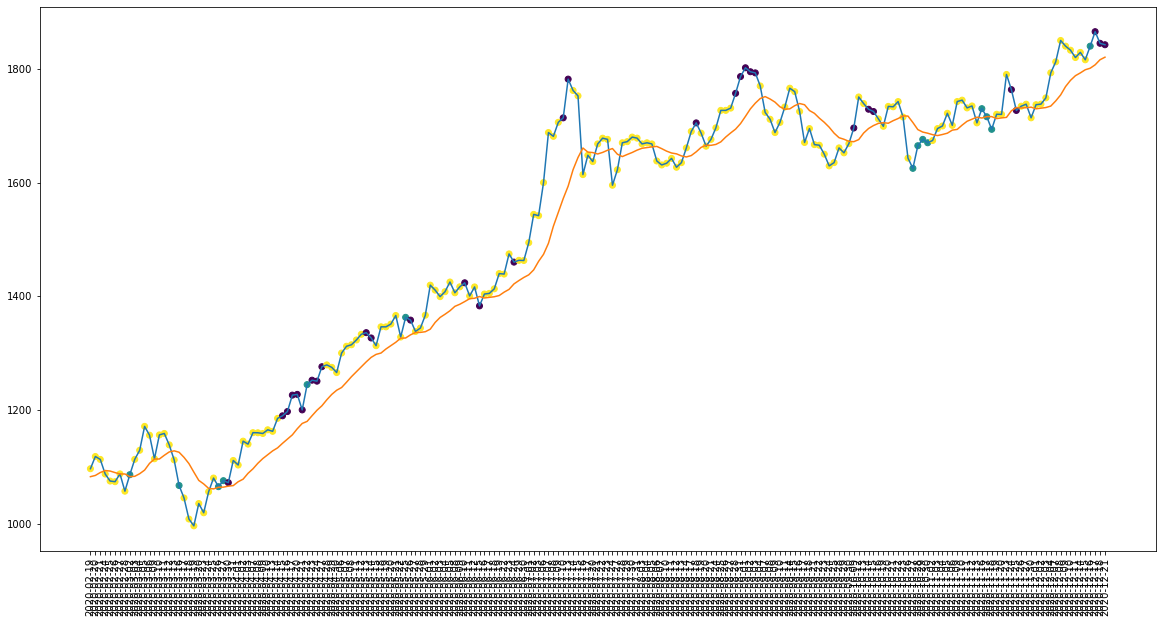

In [118]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

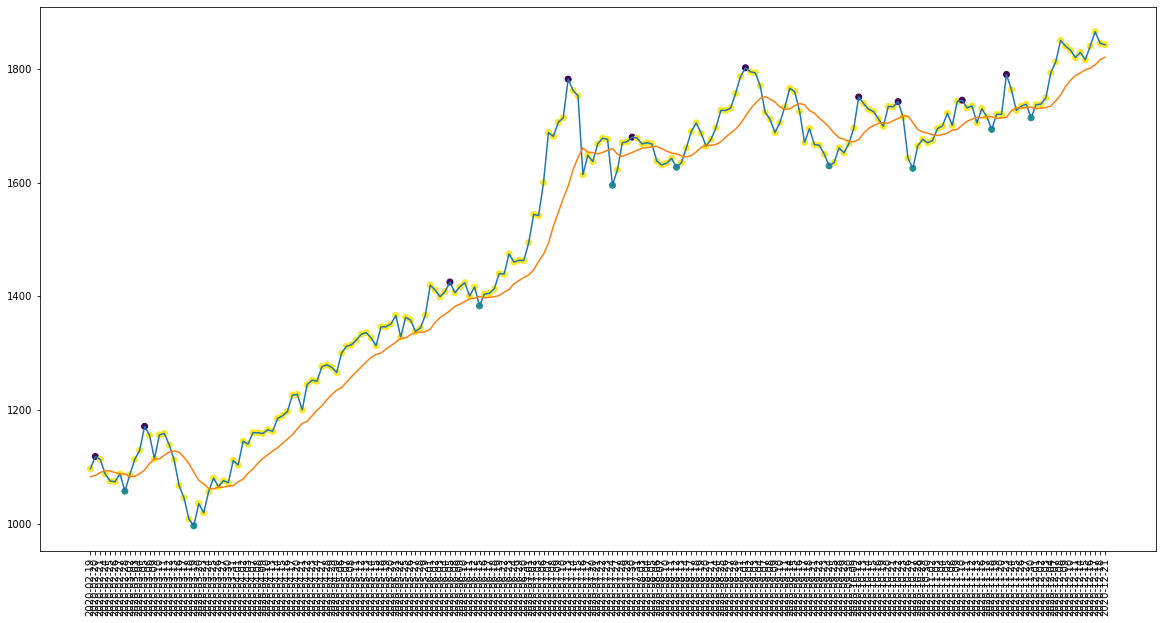

In [119]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [120]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 12
actual holds but predicted sell: 29
actual predicted holds: 148
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 20.0%
Percentage holds correct: 78.3068783068783%
actual buys: 9
actual sells: 10
actual holds: 189


In [121]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 50.0%
Percentage sells correct: 58.064516129032256%
Percentage holds correct: 85.18518518518519%


In [122]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1086.010009765625
Shares owned at the moment: 9
Cash capital at the moment: $199.03116436767596


Stop Loss Activated!

Share price: $1045.0999755859377
Shares owned at the moment: 0
Cash capital at the moment: $9579.064720245364


Share price: $1064.9200439453123
Shares owned at the moment: 8
Cash capital at the moment: $1036.276127716068


Price increase from previously bought: 11.401560528022214%
Share price: $1189.5999755859375
Shares owned at the moment: 0
Cash capital at the moment: $10526.904732940677


Share price: $1244.5
Shares owned at the moment: 8
Cash capital at the moment: $543.5257329406759


Price increase from previously bought: 7.053930431520228%
Share price: $1335.949951171875
Shares owned at the moment: 0
Cash capital at the moment: $11201.734443389894


Share price: $1362.9000244140625
Shares owned at the moment: 8
Cash capital at the moment: $268.55044754028495


Price increase from previously bought: 6.831459916515836%
Share price: $1460.0100097656

In [123]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [124]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.754032,27.272727272727273%,25.0%,79.47598253275109%,65.38461538461539%,55.55555555555556%,83.07692307692308%,7.481157219867674%,8.301816779556265%
1,0.821918,42.857142857142854%,9.090909090909092%,87.56218905472637%,93.33333333333333%,42.857142857142854%,86.84210526315789%,5.625353557167019%,25.784259382705677%
2,0.736170,20.833333333333332%,25.0%,78.87323943661971%,64.15094339622641%,70.2127659574468%,84.28184281842819%,-18.044984970779407%,-5.155468653640746%
3,0.741007,6.25%,7.6923076923076925%,81.92771084337349%,48.484848484848484%,38.46153846153846%,82.25108225108225%,-59.736331572036725%,-74.30636298537254%
4,0.730769,22.22222222222222%,20.0%,78.3068783068783%,50.0%,58.064516129032256%,85.18518518518519%,27.750204304504404%,66.41259749999998%


### bear phase test data

In [126]:
logger = []

In [127]:
seed = 10
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-01-22    32.830002  32.653718 -49.494874  128764966.0     2.0
2018-01-23    33.750000  32.822377 -18.518497  165063463.0     2.0
2018-01-24    33.970001  32.998934 -16.190425  201240854.0     2.0
2018-01-25    33.959999  33.146790 -17.627141  173336178.0     2.0
2018-01-26    34.880001  33.413438  -2.648942  221767625.0     0.0


In [128]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(595, 15, 4)

In [129]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [130]:
model = tf.keras.models.load_model("models/accumulation_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

19/19 [==============================] - 0s 3ms/step - loss: 0.1490 - accuracy: 0.7244 - mean_squared_error: 4.8899 - weighted_accuracy: 0.7244 - weighted_mean_squared_error: 4.8899
Test loss: 0.14904823899269104
Test accuracy: 0.7243697643280029


In [131]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 461, 0: 67, 1: 67})

In [132]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [133]:
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [134]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2018-02-09,32.009998,33.951521,-90.236635,104835489.0,1.0,2,1
2018-02-12,32.320000,33.652826,-74.280269,68354718.0,2.0,2,2
2018-02-13,32.919998,33.447775,-68.330148,85359125.0,2.0,2,2
2018-02-14,33.209999,33.366579,-56.813864,101567392.0,2.0,2,2
2018-02-22,34.020000,33.342490,-51.247629,113719002.0,2.0,2,2


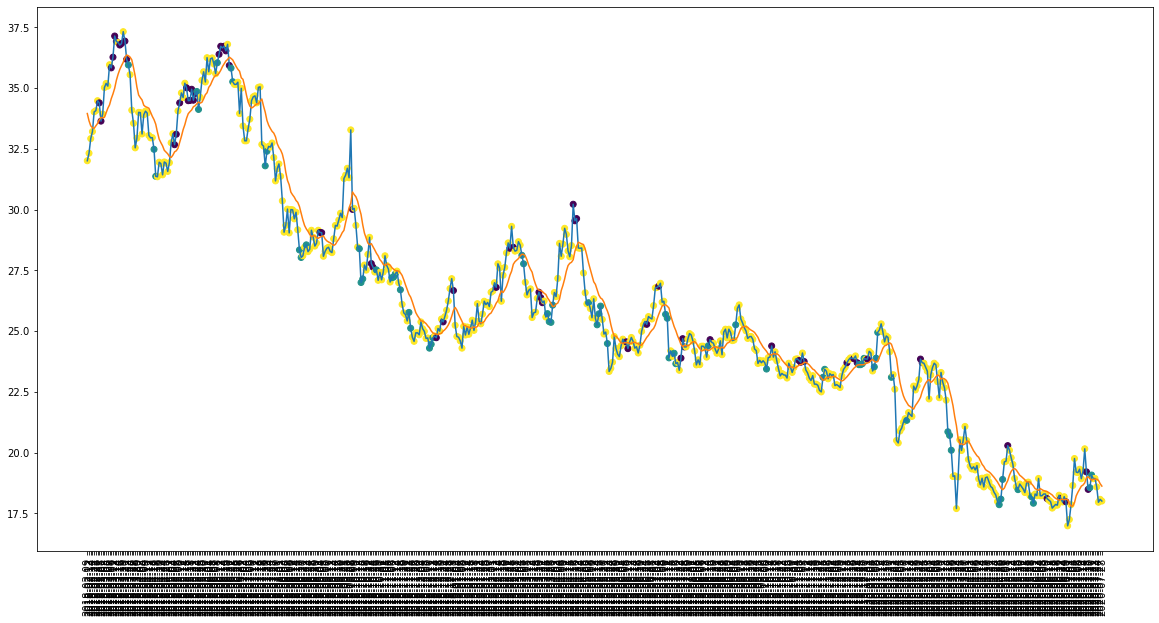

In [135]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

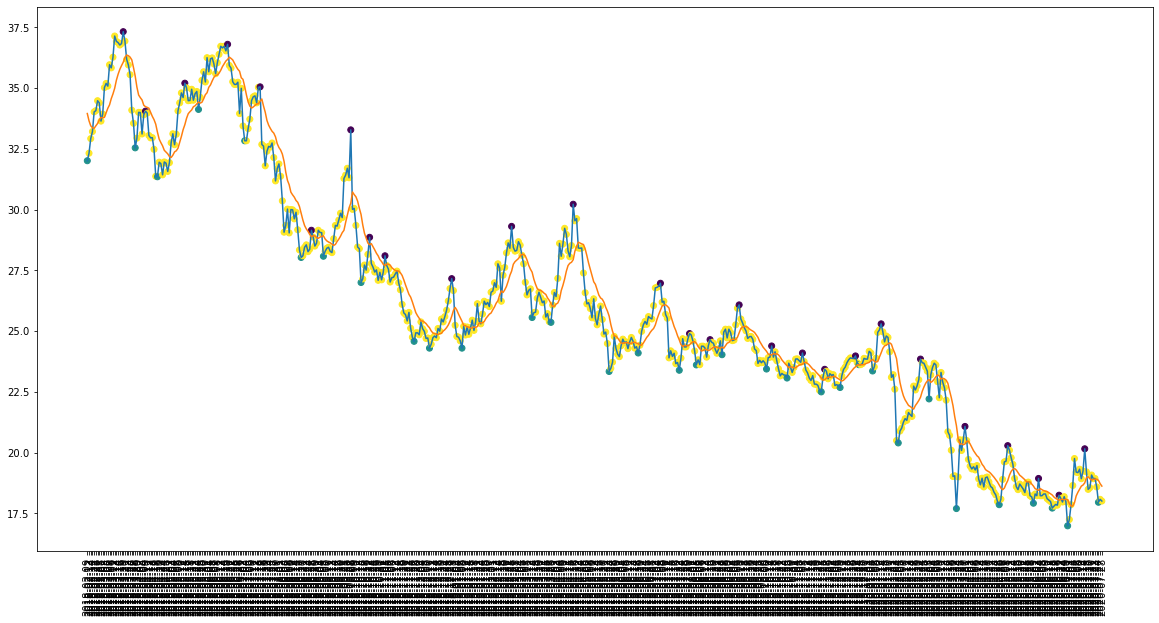

In [136]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [137]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 595
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 23
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 21
actual holds but predicted buy: 57
actual holds but predicted sell: 62
actual predicted holds: 417
Percentage buys correct: 28.125%
Percentage sells correct: 18.51851851851852%
Percentage holds correct: 77.79850746268657%
actual buys: 32
actual sells: 27
actual holds: 536


In [138]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[32.009998321533196, 32.31999969482422, 32.919998168945305, 33.209999084472656, 33.639999389648445, 34.02000045776367, 34.06999969482422, 34.389999389648445, 34.47999954223633]
[33.639999389648445, 33.93000030517578, 34.389999389648445, 34.47999954223633, 35.02000045776367, 35.080001831054695, 35.189998626708984, 35.83000183105469, 35.959999084472656]
Percentage buys correct: 49.25373134328358%
Percentage sells correct: 53.73134328358209%
Percentage holds correct: 83.26086956521739%


In [139]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $35.95000076293945
Shares owned at the moment: 277
Cash capital at the moment: $14.46487558460285


Stop Loss Activated!

Share price: $34.09000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9431.426860235215


Share price: $32.47999954223633
Shares owned at the moment: 289
Cash capital at the moment: $18.893512892724175


Stop Loss Activated!

Share price: $31.3700008392334
Shares owned at the moment: 0
Cash capital at the moment: $9059.892447264196


Share price: $31.3700008392334
Shares owned at the moment: 288
Cash capital at the moment: $0.48716490030346904


Price increase from previously bought: 5.225445417532493%
Share price: $33.09999847412109
Shares owned at the moment: 0
Cash capital at the moment: $9507.071526655673


Share price: $34.860000610351555
Shares owned at the moment: 271
Cash capital at the moment: $34.03194579553565


Price increase from previously bought: 5.046751318513998%
Share price: $36.72000122070313
Shares owned at the m

In [140]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5603.220989425184
profit gained: -43.967790105748165%


In [141]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.754032,27.272727272727273%,25.0%,79.47598253275109%,65.38461538461539%,55.55555555555556%,83.07692307692308%,7.481157219867674%,8.301816779556265%
1,0.821918,42.857142857142854%,9.090909090909092%,87.56218905472637%,93.33333333333333%,42.857142857142854%,86.84210526315789%,5.625353557167019%,25.784259382705677%
2,0.736170,20.833333333333332%,25.0%,78.87323943661971%,64.15094339622641%,70.2127659574468%,84.28184281842819%,-18.044984970779407%,-5.155468653640746%
3,0.741007,6.25%,7.6923076923076925%,81.92771084337349%,48.484848484848484%,38.46153846153846%,82.25108225108225%,-59.736331572036725%,-74.30636298537254%
4,0.730769,22.22222222222222%,20.0%,78.3068783068783%,50.0%,58.064516129032256%,85.18518518518519%,27.750204304504404%,66.41259749999998%


### Full Cycle Test Data

In [142]:
logger = []

In [143]:
seed = 10
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2002-11-11         8.74  8.763110 -71.929852 -553467352.0     2.0
2002-11-12         8.50  8.722632 -80.487816 -559735252.0     2.0
2002-11-13         8.63  8.708381 -69.918697 -552295352.0     2.0
2002-11-14         8.52  8.679399 -78.861762 -566378552.0     2.0
2002-11-15         8.80  8.697953 -56.097548 -558353452.0     2.0


In [144]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(917, 15, 4)

In [145]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [146]:
model = tf.keras.models.load_model("models/accumulation_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

29/29 [==============================] - 0s 3ms/step - loss: 0.1505 - accuracy: 0.7579 - mean_squared_error: 4.7734 - weighted_accuracy: 0.7579 - weighted_mean_squared_error: 4.7734
Test loss: 0.15048913657665253
Test accuracy: 0.7579061985015869


In [147]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 746, 1: 99, 0: 72})

In [148]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [149]:
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)

In [150]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2002-12-02,11.45,10.087284,-3.883491,-531653852.0,0.0,2,0
2002-12-03,9.96,10.296932,-13.142858,-519461852.0,2.0,2,2
2002-12-04,10.15,10.245097,-55.714280,-548693152.0,2.0,2,2
2002-12-05,10.02,10.230466,-51.764718,-529235552.0,2.0,2,2
2002-12-06,9.88,10.198087,-55.588224,-540995752.0,2.0,2,2


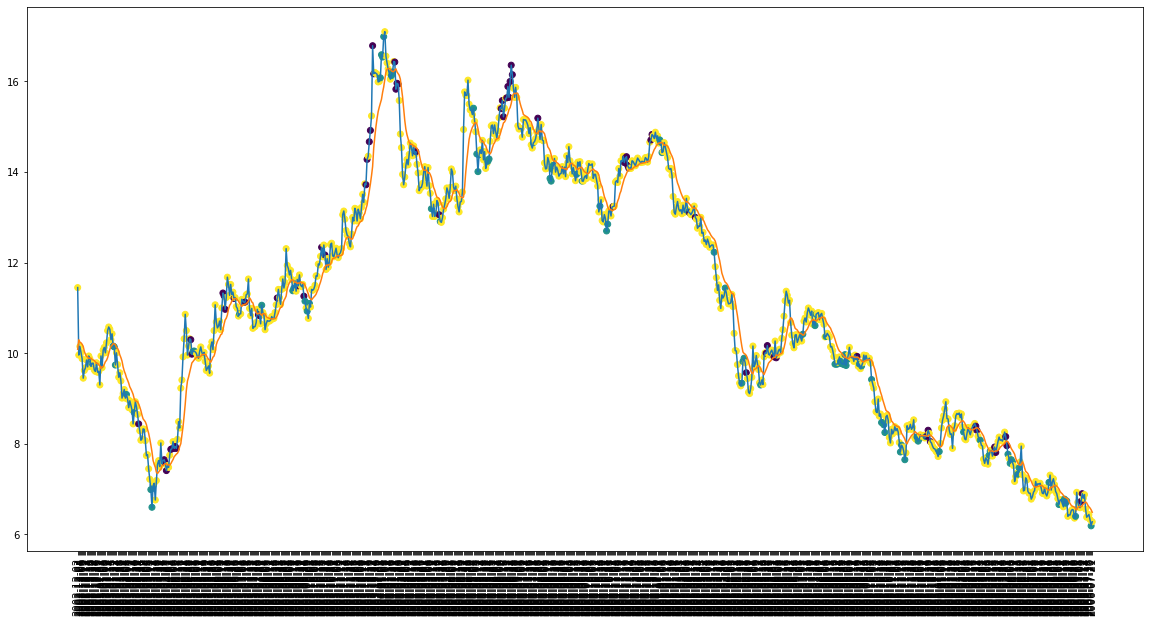

In [151]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

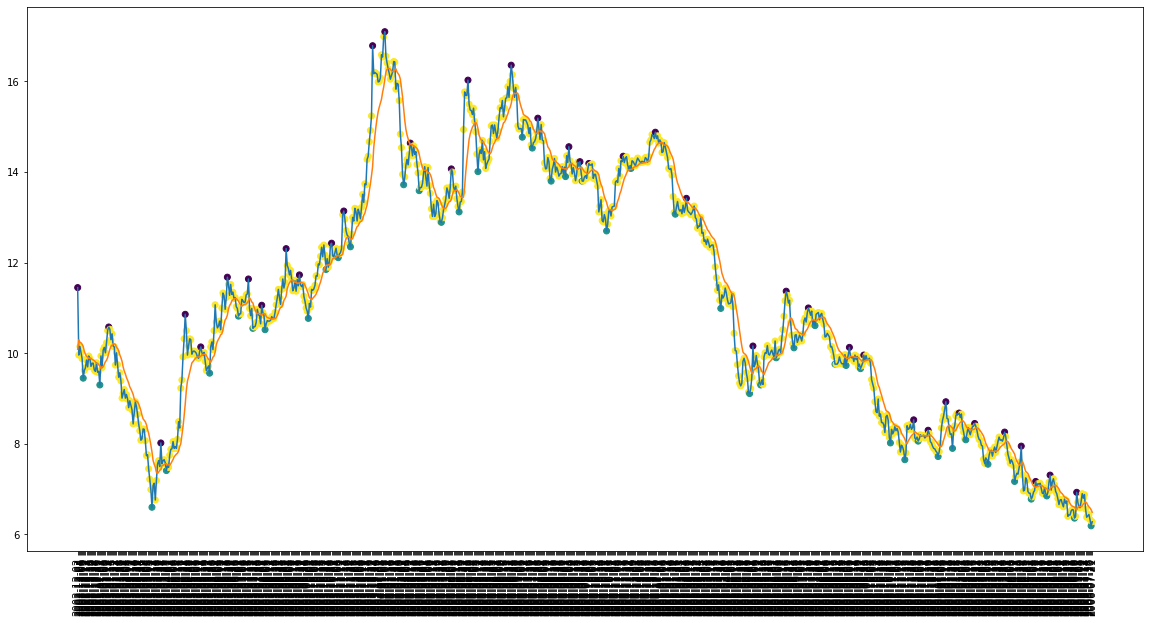

In [152]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 917
actual predicted buys: 12
actual buys but predicted sell: 2
actual buys but predicted hold: 32
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 35
actual holds but predicted buy: 86
actual holds but predicted sell: 66
actual predicted holds: 679
Percentage buys correct: 26.08695652173913%
Percentage sells correct: 10.0%
Percentage holds correct: 81.70878459687124%
actual buys: 46
actual sells: 40
actual holds: 831


In [154]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[9.449999809265137, 9.619999885559082, 9.68000030517578, 9.850000381469727, 9.880000114440918, 9.960000038146973, 10.020000457763672, 10.149999618530273, 11.449999809265135]
[9.619999885559082, 9.68000030517578, 9.699999809265137, 9.710000038146973, 9.779999732971193, 9.779999732971193, 9.850000381469727, 9.880000114440918, 9.9399995803833]
Percentage buys correct: 57.57575757575758%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 84.29530201342281%


In [155]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.779999732971193
Shares owned at the moment: 1019
Cash capital at the moment: $6.774267850634715


Stop Loss Activated!

Share price: $9.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9457.413536674974


Share price: $10.15999984741211
Shares owned at the moment: 928
Cash capital at the moment: $3.0053586659414577


Stop Loss Activated!

Share price: $9.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9016.868666847704


Share price: $9.739999771118164
Shares owned at the moment: 923
Cash capital at the moment: $2.1263236865979707


Stop Loss Activated!

Share price: $9.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $8718.899341976401


Share price: $9.09000015258789
Shares owned at the moment: 956
Cash capital at the moment: $4.961585701223157


Stop Loss Activated!

Share price: $8.800000190734863
Shares owned at the moment: 0
Cash capital at the moment: $8394.626567542311


Share price: $

In [156]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5459.681323426963
profit gained: -45.40318676573037%


In [157]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.754032,27.272727272727273%,25.0%,79.47598253275109%,65.38461538461539%,55.55555555555556%,83.07692307692308%,7.481157219867674%,8.301816779556265%
1,0.821918,42.857142857142854%,9.090909090909092%,87.56218905472637%,93.33333333333333%,42.857142857142854%,86.84210526315789%,5.625353557167019%,25.784259382705677%
2,0.736170,20.833333333333332%,25.0%,78.87323943661971%,64.15094339622641%,70.2127659574468%,84.28184281842819%,-18.044984970779407%,-5.155468653640746%
3,0.741007,6.25%,7.6923076923076925%,81.92771084337349%,48.484848484848484%,38.46153846153846%,82.25108225108225%,-59.736331572036725%,-74.30636298537254%
4,0.730769,22.22222222222222%,20.0%,78.3068783068783%,50.0%,58.064516129032256%,85.18518518518519%,27.750204304504404%,66.41259749999998%
5,0.724370,28.125%,18.51851851851852%,77.79850746268657%,49.25373134328358%,53.73134328358209%,83.26086956521739%,-31.992137296094963%,-43.967790105748165%
6,0.757906,26.08695652173913%,10.0%,81.70878459687124%,57.57575757575758%,44.44444444444444%,84.29530201342281%,-33.276082279896904%,-45.40318676573037%


In [158]:
experiment

'Accumulation Phase LSTM Time Series'

In [159]:
if not os.path.exists('{}.csv'.format(experiment)):
            log.to_csv('{}.csv'.format(experiment))